<a href="https://colab.research.google.com/github/marcomedugno/Personal-Projects/blob/main/Left%2C_Right%2C_and_Center_Stage_Comedy's_Political_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Left, Right, and Center Stage: Comedy's Political Evolution**

*by Marco Medugno*

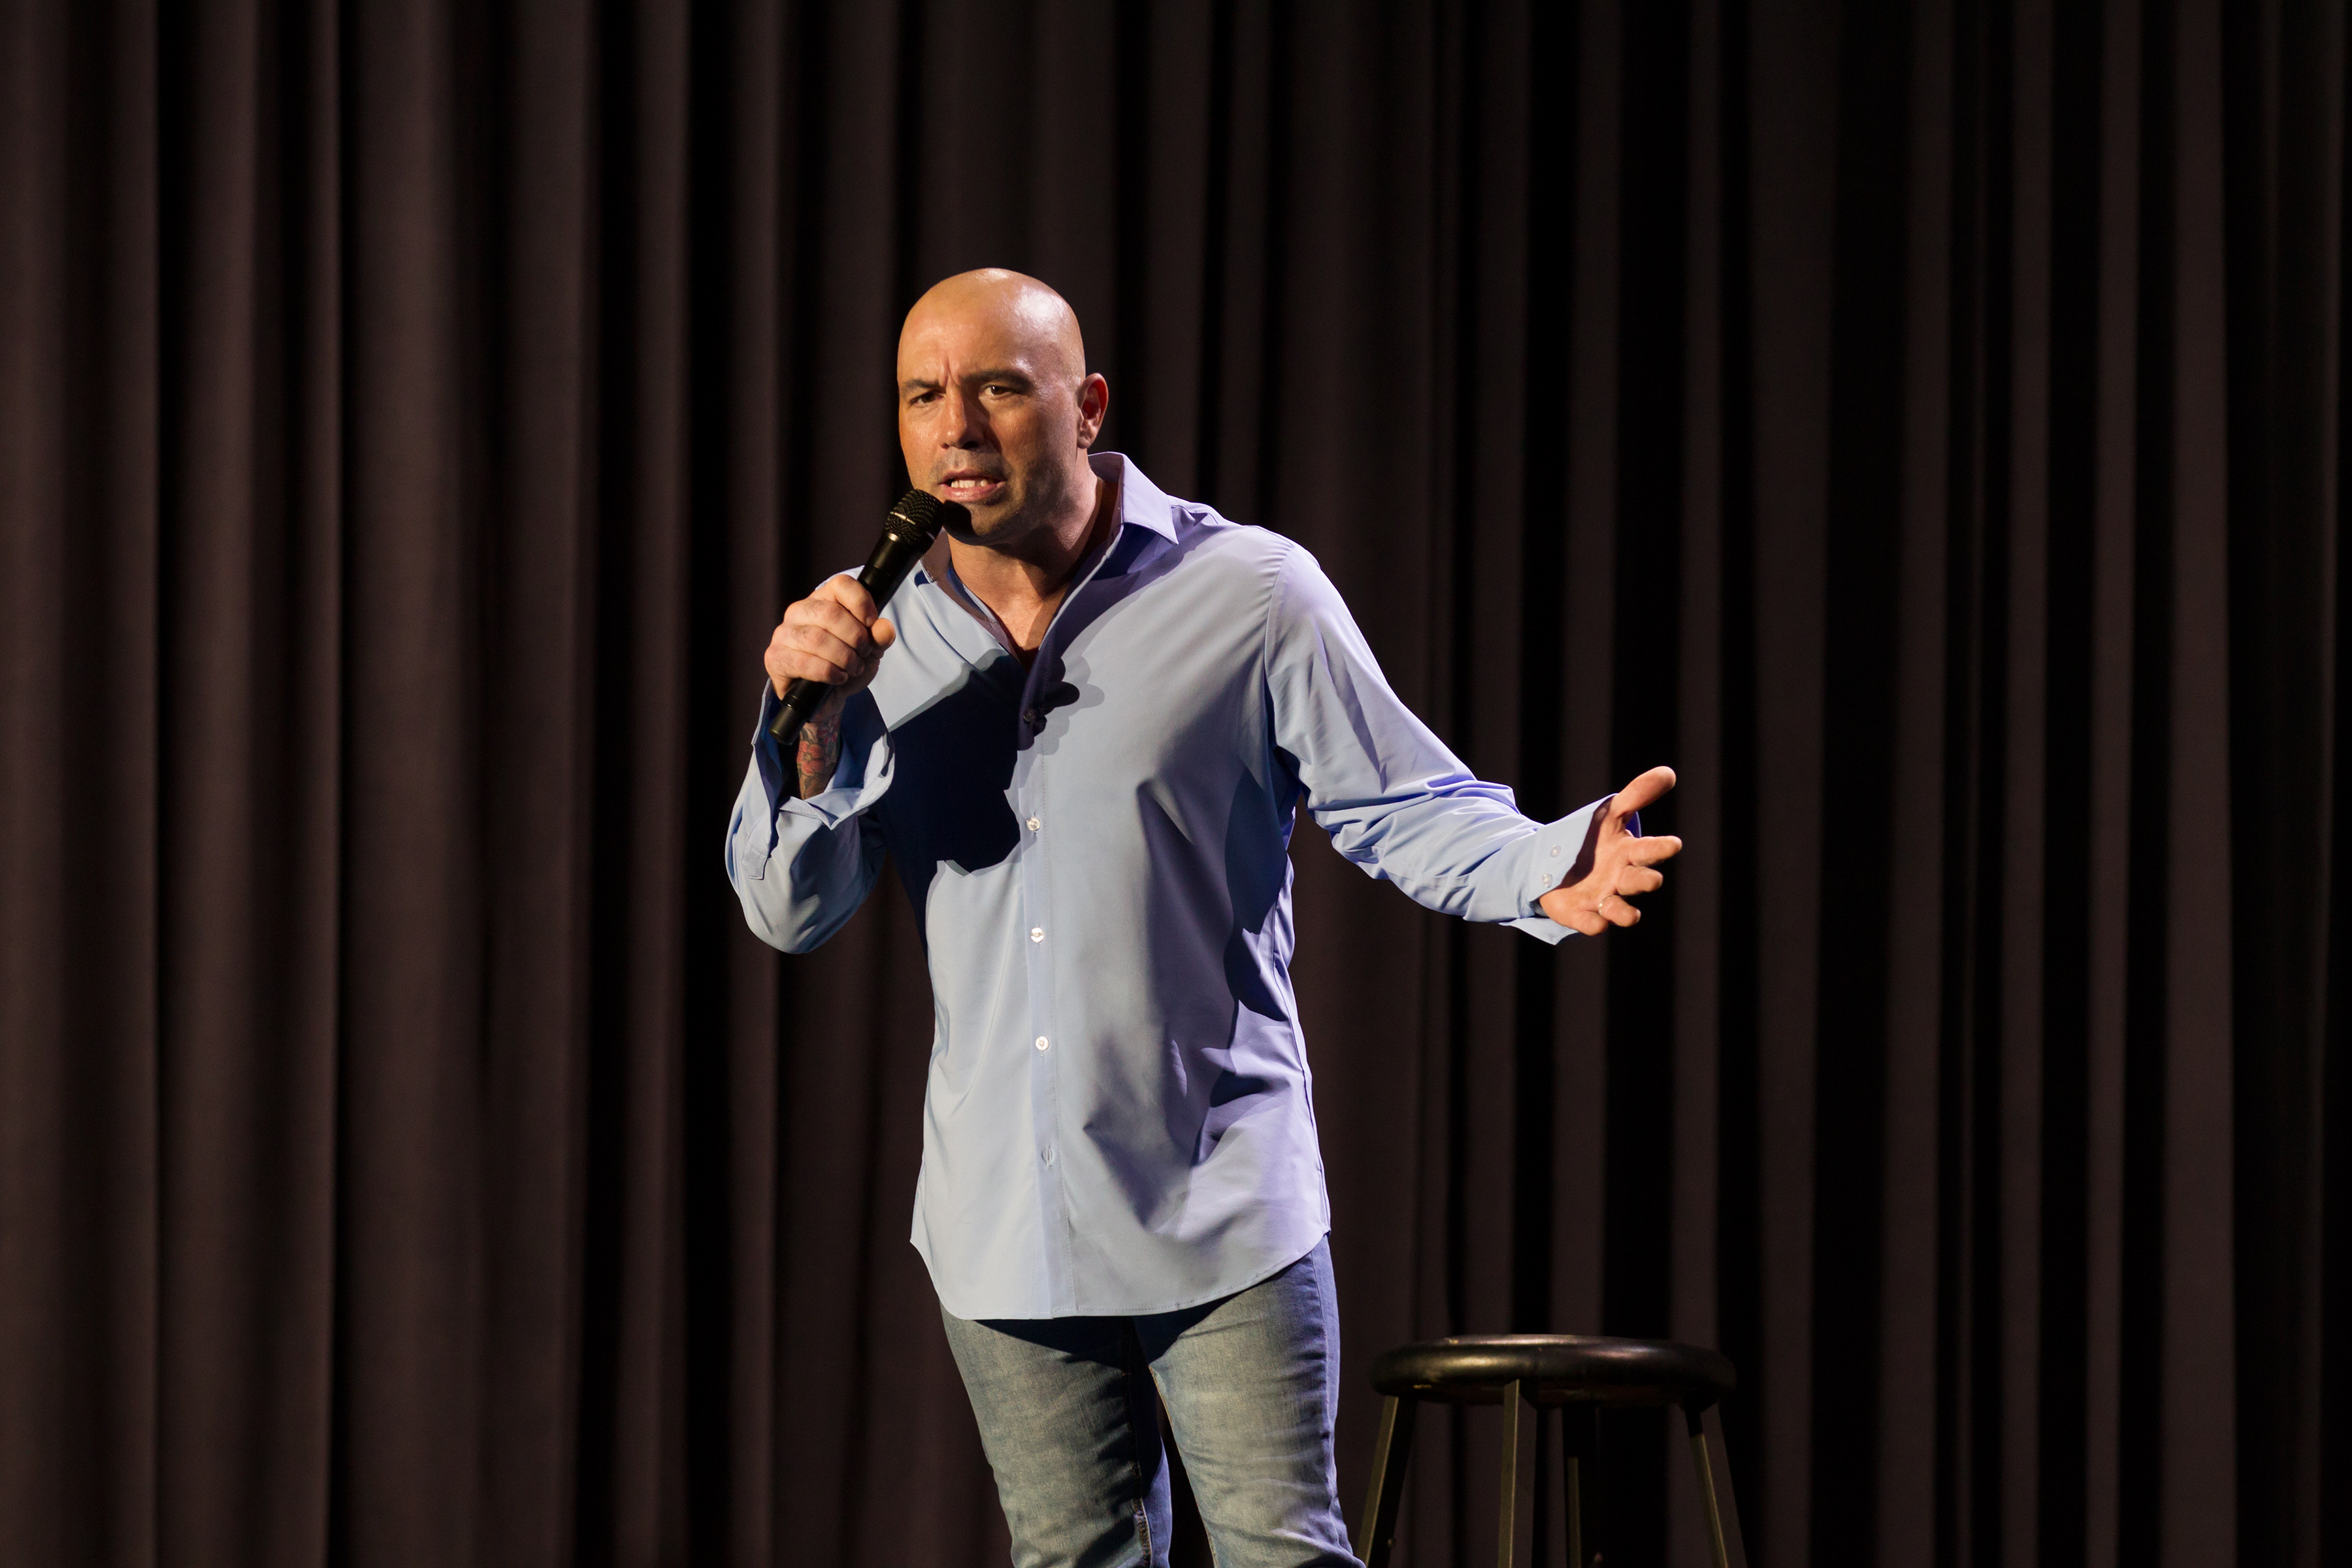

In [1]:
# @title
from IPython.display import Image
display(Image('https://cloudfront-us-east-1.images.arcpublishing.com/tbt/TNTF4CZOO5BEFGIT7LCRCBXS54.jpg', width=1400))

Over the past year, there has been lots of talk of the resurgence of right-wing comedy, with key figures like Joe Rogan, Andrew Schulz, and Tony Hinchcliffe selling out venues across the globe, and wracking up lots of airline miles to Austin, Texas.

Despite the discourse on the comeback of anti-wokeness on podcasts, I remained curious if this actually holds true. As someone who attends a lot of comedy shows in NYC, I still see far more left-leaning sets, but that's expected given the local political climate.

To finally get an answer, I thought about posing as a talent agent from SNL to trick comedians into filling out my political poll, but I quickly realized that comedians thrive on calling out people's BS.

I thought I was out of luck until I found a wonderful website called ["Scraps From The Loft"](https://scrapsfromtheloft.com/stand-up-comedy-scripts/), which has collected a treasure trove of stand-up special transcripts throughout the years.

With this unexpected goldmine of comedic content at my fingertips, I saw an opportunity to take a more data-driven approach.

Instead of relying on headlines or hot takes, I turned to Natural Language Processing to measure the political drift of these sets. My goal wasn't to definitvely label comedians as "left" or "right", but rather to observe how themes and tone have shifted over time.

This project is my attempt to see whether the stage has really shifted right, stayed left, or like a good joke, landed somewhere unexpected.

In [60]:
# @title
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

*Code cells were hidden for brevity. Click on 'Show code' to see the contents of the code.*

In [2]:
# @title
# Import Libraries

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from google import genai
from google.genai import types
import time
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

To build a dataset worthy of analysis, I scraped transcripts from Scraps From the Loft. Rather than cherry-picking a few favorites, I built a web scraper using BeautifulSoup to gather transcripts programmatically. The script first crawls the site's index of stand-up specials, filters out non-transcript links, and then visits each page to extract:


*   The **comedian's name**
*   The **year** (parsed from the title)
*   The **special's title**
*   The **transcript text** itself, minus fillers like music notes or audience applause

The result is a tidy DataFrame where each row represents a single special, ready for analysis.



In [3]:
# @title
# Scape Stand up Comedy Transcripts

def get_comedy_links(url):
  '''
  Grabs all links from a website. This will be used to find all stand up comedy transcripts on Scraps from the Loft.

  Args:
    url: URL of the page to scrape.

  Returns:
    links: List of all comedy transcript links on the page.

  '''
  links = []

  # find all links on a webpage and append links
  response = requests.get(url)
  soup = BeautifulSoup(response.content, "html.parser")
  for link in soup.find_all('a'):
    # Only grab links that are valid transcripts
    if link.get('href'):
      href = link.get('href')
      if '/comedy/' in href and not href.endswith('/comedy/'):
        links.append(link.get('href'))
  links = list(set(links))

  return links

In [4]:
# @title
def get_transcript(transcript_url):
  '''
  Grabs the comedian, year, title, and text from a stand up comedy transcript.

  Args:
    transcript_url: URL of the transcript to scrape.

  Returns:
    comedian: Name of the comedian.
    year: Year of the comedy special.
    title: Title of the transcript.
    text: Text of the transcript.

  '''

  # Scrape Transcript URL
  response = requests.get(transcript_url)
  soup = BeautifulSoup(response.content, "html.parser")

  # Grab Title
  title = soup.title.string.strip()

  # Remove Scraps from the Loft signature
  title = title.replace(" | Transcript - Scraps from the loft", "")
  title = title.replace(" - FULL TRANSCRIPT - Scraps from the loft", "")
  title = title.replace(" - Full Transcript - Scraps from the loft", "")

  # Get Comedian
  if ": " in title:
    comedian = title.split(": ")[0]
    comedian = comedian.title()   # standardize capitalization
    title = title.split(": ")[1]
  else:
    comedian = None

  # Get Year
  if "(20" in title:
    year = '20' + title.split("(20")[1][:2]
    title = title.split("(20")[0]
  elif "(19" in title:
    year = '19' + title.split("(19")[1][:2]
    title = title.split("(19")[0]
  else:
    year = None

  # Get Text
  content_div = soup.find("div", class_="elementor-widget-theme-post-content")
  if content_div:
      paragraphs = content_div.find_all("p")
      text_lines = []
      for p in paragraphs:
          # Skip if paragraph contains <em> or <i> tags. This usually reflects descriptions/summaries written by SFTL
          if p.find("em") or p.find("i"):
              continue
          text_lines.append(p.get_text(strip=True))
      text = "\n".join(text_lines)

      # Clean up extracted text
      text = re.sub(r'\[.*?\]', '', text)         # Remove anything in square brackets
      text = text.replace('\n',' ')               # Remove newlines
      text = text.replace('♪', '')                # Remove music notes
      text = text.replace('*', '')                # Remove asterisks
      text = re.sub(r'\s+', ' ', text).strip()    # Normalize Whitespace
  else:
      text = None

  return transcript_url, comedian, year, title, text

In [5]:
# @title
def create_df_from_links(links):

  '''
  Creates a dataframe from a list of links. This calls the get_transcript function on each link.

  Args:
    links: List of links to scrape.

  Returns:
    df: Dataframe with the following columns:
      - transcript_url: URL of the transcript.
      - comedian: Name of the comedian.
      - year: Year of the comedy special.
      - title: Title of the transcript.
      - text: Text of the transcript.

  '''

  comedy_dict = {
    "transcript_url": [],
    "comedian": [],
    "year": [],
    "title": [],
    "text": []
  }

  for link in links:
    transcript_url, comedian, year, title, text = get_transcript(link)

    comedy_dict["transcript_url"].append(transcript_url)
    comedy_dict["comedian"].append(comedian)
    comedy_dict["year"].append(year)
    comedy_dict["title"].append(title)
    comedy_dict["text"].append(text)

  df = pd.DataFrame(comedy_dict)

  return df

In [20]:
url  = "https://scrapsfromtheloft.com/stand-up-comedy-scripts/"

links = get_comedy_links(url)
df = create_df_from_links(links)

Here's a look at the 10 most recent entires pulled from the dataset:

In [23]:
df.sort_values(by='year', ascending=False).head(10)

transcript_url          comedian  \
214  https://scrapsfromtheloft.com/comedy/gabriel-i...  Gabriel Iglesias   
138  https://scrapsfromtheloft.com/comedy/bill-mahe...        Bill Maher   
140  https://scrapsfromtheloft.com/comedy/bert-krei...    Bert Kreischer   
207  https://scrapsfromtheloft.com/comedy/chelsea-h...   Chelsea Handler   
329  https://scrapsfromtheloft.com/comedy/iliza-shl...  Iliza Shlesinger   
71   https://scrapsfromtheloft.com/comedy/ari-shaff...       Ari Shaffir   
371  https://scrapsfromtheloft.com/comedy/alex-edel...      Alex Edelman   
340  https://scrapsfromtheloft.com/comedy/tig-notar...        Tig Notaro   
171  https://scrapsfromtheloft.com/comedy/sam-morri...        Sam Morril   
460  https://scrapsfromtheloft.com/comedy/phil-wang...         Phil Wang   

     year                         title  \
214  2025             Legend of Fluffy    
138  2025  Is Anyone Else Seeing This?    
140  2025                        Lucky    
207  2025                  The Feeling    
329  2025           A Different Animal    
71   2025         America's Sweetheart    
371  2024                  Just for Us    
340  2024                  Hello Again    
171  2024               You've Changed    
460  2024         Wang in There, Baby!    

                                                  text  
214  Fluffy! Man, look at this crowd. They are goin...  
138  The stand-up special premiered on January 10, ...  
140  It is nice to be home. It’s also nice to not b...  
207  Oh my God! Oh, hello, New Jersey. Welcome! I’m...  
329  Salt Lake City! Thank you! Thank you so much. ...  
71   Every town, I figured out, every city gets eit...  
371  Standup comic Alex Edelman’s Broadway show, fe...  
340  Tig Notaro: Hello Again (2024) Released on Mar...  
171  All right, Boston. Keep it going. Keep it goin...  
460  Phil Wang: Wang in There, Baby! (2024)Release ...

While the scraper successfully parsed the comedian and title from the majority of transcripts, it wasn't foulproof. Some entries didn't follow the expected formatting patterns in their titles, leading to a few NA values in the comedian column.

Below, we take a look at the rows where the comedian's name couldn't be extracted:

In [26]:
df[df['comedian'].isna()]

transcript_url comedian  year  \
2    https://scrapsfromtheloft.com/comedy/saturday-...     None  None   
10   https://scrapsfromtheloft.com/comedy/nate-barg...     None  2024   
15   https://scrapsfromtheloft.com/comedy/bill-mahe...     None  2010   
16   https://scrapsfromtheloft.com/comedy/sammy-obe...     None  None   
27   https://scrapsfromtheloft.com/comedy/richard-p...     None  None   
41   https://scrapsfromtheloft.com/comedy/tom-segur...     None  None   
47   https://scrapsfromtheloft.com/comedy/carlin-at...     None  1983   
52   https://scrapsfromtheloft.com/comedy/michael-c...     None  2016   
53   https://scrapsfromtheloft.com/comedy/george-ca...     None  None   
63   https://scrapsfromtheloft.com/comedy/mark-norm...     None  2019   
93   https://scrapsfromtheloft.com/comedy/dave-chap...     None  None   
134  https://scrapsfromtheloft.com/comedy/shane-gil...     None  None   
162  https://scrapsfromtheloft.com/comedy/sincerely...     None  2020   
173  https://scrapsfromtheloft.com/comedy/eddie-izz...     None  1997   
177  https://scrapsfromtheloft.com/comedy/robin-wil...     None  2002   
206  https://scrapsfromtheloft.com/comedy/oh-hello-...     None  2017   
217  https://scrapsfromtheloft.com/comedy/doug-stan...     None  None   
221  https://scrapsfromtheloft.com/comedy/rory-scov...     None  2017   
261  https://scrapsfromtheloft.com/comedy/ramy-yous...     None  None   
266  https://scrapsfromtheloft.com/comedy/nate-barg...     None  None   
269  https://scrapsfromtheloft.com/comedy/the-roast...     None  2024   
272  https://scrapsfromtheloft.com/comedy/sebastian...     None  2019   
285  https://scrapsfromtheloft.com/comedy/jim-jeffe...     None  None   
307  https://scrapsfromtheloft.com/comedy/brazil-co...     None  None   
336  https://scrapsfromtheloft.com/comedy/sammy-obe...     None  None   
341  https://scrapsfromtheloft.com/comedy/rowan-atk...     None  1992   
347  https://scrapsfromtheloft.com/comedy/ryan-hami...     None  2019   
348  https://scrapsfromtheloft.com/comedy/your-frie...     None  2024   
351  https://scrapsfromtheloft.com/comedy/trevor-no...     None  None   
355  https://scrapsfromtheloft.com/comedy/jeff-dunh...     None  2024   
384  https://scrapsfromtheloft.com/comedy/jon-stewa...     None  None   
394  https://scrapsfromtheloft.com/comedy/kenny-seb...     None  2017   
415  https://scrapsfromtheloft.com/comedy/larry-the...     None  2020   
422  https://scrapsfromtheloft.com/comedy/bill-burr...     None  2010   
425  https://scrapsfromtheloft.com/comedy/volker-pi...     None  2004   
435  https://scrapsfromtheloft.com/comedy/louis-ck-...     None  2023   
440  https://scrapsfromtheloft.com/comedy/george-ca...     None  1977   
452  https://scrapsfromtheloft.com/comedy/dave-chap...     None  2022   
459  https://scrapsfromtheloft.com/comedy/joe-mande...     None  2017   
475  https://scrapsfromtheloft.com/comedy/chris-roc...     None  1996   
496  https://scrapsfromtheloft.com/comedy/doug-stan...     None  None   

                                                 title  \
2    Saturday Night News with George Carlin [11/10/...   
10                Nate Bargatze's Nashville Christmas    
15                    BILL MAHER... BUT I'M NOT WRONG    
16                 Sammy Obeid on Palestine Censorship   
27   RICHARD PRYOR'S MONOLOGUE AT THE SATURDAY NIGH...   
41   Tom Segura Overdoses - This Is Not Happening [...   
47                                 Carlin at Carnegie    
52                                Michael Che Matters    
53   GEORGE CARLIN ON ABORTION AND "PRO-LIFERS" - S...   
63   Mark Normand Stand-Up - The Tonight Show Starr...   
93   Dave Chappelle Acceptance Speech | 2019 Mark T...   
134              Shane Gillis Stand-Up Monologue - SNL   
162                                SINCERELY LOUIS CK    
173                           Eddie Izzard - Glorious    
177                   ROBIN WILLIAMS LIVE ON BROADWAY    
206                             Oh, Hello On 

Rather than dropping these entries, and losing valuable material, or manually correcting them (a nightmare at scale), I turned to a much more efficient solution: a language model.

Using Gemini 2.5 Flash Lite Preview (a lightweight, fast-response model from Google), I built a simple augmentation function that prompts the LLM with the title of the comedy special and a clear set of instructions.

This kind of LLM-powered augmentation has been tremendously helpful for me when dealing with unstructured or inconsistently formatted data, and traditional, catch-all logic is not so simple to implement.

I chose Gemini 2.5 Flash Lite for its fast inference time, low hallucination rate, and ability to handle structured extraction tasks without unneccessary verbosity.

After running the model only on the rows with missing names, we were able to recover many valid entries, saving time and enriching the dataset for downstream analysis.


In [42]:
# @title
# You can get an API key to use Gemeni from Google Cloud Console
gemini_api_key = 'HIDDEN'

In [43]:
# @title
def get_comedian_name_from_llm(special, gemini_api_key):
  '''
  This function calls Gemeni's 2.5 Flash Lite Preview 06-17 Model to extract the comedian name from the special's title.

  Args:
    special: Title of the comedy special.
    open_router_api_key: API key for OpenRouter.

  Returns:
    Name of the comedian.
  '''


  prompt = f"""
    Task: Extract the name of the comedian from the title of a comedy special.

    Rules:
    - Only return the name if it is clearly stated in the title.
    - Return the comedian's first and last name.
    - If the title refers to a roast (e.g., "The Roast of X"), do not treat X as the comedian — return: None.
    - If no name is clearly mentioned, return: None
    - Do not infer, guess, or hallucinate names.

    Title: "{special}"
  """

  client = genai.Client(api_key = gemini_api_key)

  response = client.models.generate_content(
      model = 'gemini-2.5-flash-lite-preview-06-17',
      contents = prompt,
      config = types.GenerateContentConfig(
          temperature=0.0
      )
  )

  print(response.text)

  return response.text

In [44]:
# @title
def fill_missing_comedians(df, open_router_api_key):
  '''
  This function calls the get_comedian_name_from_llm function on all rows in df where comedian is na.

  Args:
    df: dataframe where comedy special data is stored.
    open_router_api_key: API key for OpenRouter.

  Returns:
    df: dataframe with missing comedian names filled in.
  '''

  # Iterate over rows where 'comedian' is NaN
  for idx, row in df[df['comedian'].isna()].iterrows():
      special = row['title']
      try:
          name = get_comedian_name_from_llm(special, open_router_api_key)
          df.at[idx, 'comedian'] = name
      except Exception as e:
          print(f"Error for index {idx} and special '{special}': {e}")

  return df


In [45]:
df = fill_missing_comedians(df, gemini_api_key)

George Carlin
Nate Bargatze
Bill Maher
Sammy Obeid
Richard Pryor
Tom Segura
Carlin
Michael Che
George Carlin
Mark Normand
Dave Chappelle
Shane Gillis
Louis CK
Eddie Izzard
ROBIN WILLIAMS
None
Doug Stanhope
Rory Scovel
Ramy Youssef
Nate Bargatze
None
Sebastian Maniscalco
Jim Jefferies
Hasan Minhaj
Sammy Obeid
Rowan Atkinson
Ryan Hamilton
Nate Bargatze
Trevor Noah
Jeff Dunham
Jon Stewart
Kenny Sebastian
Larry the Cable Guy
Bill Burr
Volker Pispers
Louis C.K.
George Carlin
Dave Chappelle
Joe Mande
CHRIS ROCK
Doug Stanhope


Even after using the LLM to recover missing comedian names, a bit more pruning was necessary. Specfically, I dropped rows where:


*   The LLM returned 'None', meaning it couldn't confidently extract a name from the title. Many of these are not traditional stand-up specials, but rather comedic plays, roasts, etc.
*   The transcript text itself was missing or failed to scrape properly

These rows either lacked attribution or content. Removing them ensures we're working with a clean, reliable dataset composed of complete specials with identifiable comedians.



In [64]:
df = df[~(df['comedian'] == 'None') & ~(df['text'].isna())]

To provide a structured political reference point for the comedy transcripts, I scraped the last 50 State of the Union (SOTU) addresses from the American Presidency Project at UCSB. These SOTU addresses offer a reliable benchmark for what politics usually sounds like across different presidents and time periods.

Once again, I used a BeautifulSoup scraper and looped through the first five pages of the archive, grabbing all the links to individual addresses.

By comparing stand-up sets to these speeches, we get:


*   A structured benchmark for political language across parties and decades.
*   A way to measure comedic content semantically, without needing to manually tag it as "liberal" or "conservative".
*   A reminder that  no issue is too complex for a three-word slogan

In [53]:
# @title
def get_sotu_links(page_url):

    links = []
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all the <div class="field-title"> and extract <a href>
    speech_blocks = soup.find_all("div", class_="field-title")

    for block in speech_blocks:
        a_tag = block.find("a")
        if a_tag and "href" in a_tag.attrs:
            relative_url = a_tag["href"]
            full_url = f"https://www.presidency.ucsb.edu{relative_url}"
            links.append(full_url)

    return links


In [54]:
# @title
base_url = "https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses"

all_sotu_links = []

for page in range(5):
    if page == 0:
        url = base_url  # First page has no ?page=0
    else:
        url = f"{base_url}?page={page}"
    print(f"Scraping page: {url}")
    page_links = get_sotu_links(url)
    all_sotu_links.extend(page_links)

# remove duplicates
all_sotu_links = list(set(all_sotu_links))

print(f"Collected {len(all_sotu_links)} unique SOTU links.")


Scraping page: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses
Scraping page: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses?page=1
Scraping page: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses?page=2
Scraping page: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses?page=3
Scraping page: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses?page=4
Collected 50 unique SOTU links.


With our list of State of the Union links in hand, the next step is to dive into each page and extract the actual content. Using a simple parser, I pulled out three key elements from each address:



*   The date it was delivered
*   The president who delivered it
*   The full text of the speech

This gave us a structured dataset of political rhetoric stretching back to the Lyndon B. Johnson era, covering everything from Cold War anxieties to broadband access.

Once parsed, all of the speeches were compiled into a tidy DataFrame.



In [55]:
# @title
def parse_sotu_page(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    date_tag = soup.find("span", class_="date-display-single")
    content_tag = soup.find("div", class_="field-docs-content")
    president_tag = soup.find("h3", class_="diet-title")

    # Extract text safely
    date = date_tag.text.strip() if date_tag else "Unknown"
    text = content_tag.text.strip() if content_tag else "No transcript found"
    president = president_tag.text.strip() if president_tag else "Unknown"

    return {
        "url": url,
        "date": date,
        "president": president,
        "text": text
    }


In [56]:
# @title
# Scrape all State of the Union Adddresses since Lyndon Johnson
sotu_data = []

for i, url in enumerate(all_sotu_links):
    try:
        print(f"[{i+1}/{len(all_sotu_links)}] Scraping: {url}")
        record = parse_sotu_page(url)
        sotu_data.append(record)
    except Exception as e:
        print(f"Failed on {url}: {e}")

# Convert to DataFrame
df_sotu = pd.DataFrame(sotu_data)

[1/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-12
[2/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-congress-the-state-the-union-1
[3/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-13
[4/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-reporting-the-state-the-union-2
[5/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-24
[6/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-22
[7/50] Scraping: https://www.presidency.ucsb.edu/documents/address-before-joint-session-the-congress-the-state-the-union-4
[8/50] Scraping: https://www.presidency.ucsb.edu/documents/annual-message-the-congress-the-state-the-union-1
[9/50] Scraping: htt

In [57]:
df_sotu['date'] = pd.to_datetime(df_sotu['date'])
df_sotu = df_sotu.sort_values(by='date', ascending=False)

df_sotu

url       date  \
49  https://www.presidency.ucsb.edu/documents/addr... 2024-03-07   
24  https://www.presidency.ucsb.edu/documents/addr... 2023-02-07   
33  https://www.presidency.ucsb.edu/documents/addr... 2022-03-01   
10  https://www.presidency.ucsb.edu/documents/addr... 2020-02-04   
23  https://www.presidency.ucsb.edu/documents/addr... 2019-02-05   
48  https://www.presidency.ucsb.edu/documents/addr... 2018-01-30   
17  https://www.presidency.ucsb.edu/documents/addr... 2016-01-12   
20  https://www.presidency.ucsb.edu/documents/addr... 2015-01-20   
15  https://www.presidency.ucsb.edu/documents/addr... 2014-01-28   
42  https://www.presidency.ucsb.edu/documents/addr... 2013-02-12   
25  https://www.presidency.ucsb.edu/documents/addr... 2012-01-24   
43  https://www.presidency.ucsb.edu/documents/addr... 2011-01-25   
38  https://www.presidency.ucsb.edu/documents/addr... 2010-01-27   
39  https://www.presidency.ucsb.edu/documents/addr... 2008-01-28   
9   https://www.presidency.ucsb.edu/documents/addr... 2007-01-23   
2   https://www.presidency.ucsb.edu/documents/addr... 2006-01-31   
18  https://www.presidency.ucsb.edu/documents/addr... 2005-02-02   
4   https://www.presidency.ucsb.edu/documents/addr... 2004-01-20   
12  https://www.presidency.ucsb.edu/documents/addr... 2003-01-28   
5   https://www.presidency.ucsb.edu/documents/addr... 2002-01-29   
36  https://www.presidency.ucsb.edu/documents/addr... 2000-01-27   
34  https://www.presidency.ucsb.edu/documents/addr... 1999-01-19   
19  https://www.presidency.ucsb.edu/documents/addr... 1998-01-27   
22  https://www.presidency.ucsb.edu/documents/addr... 1997-02-04   
14  https://www.presidency.ucsb.edu/documents/addr... 1996-01-23   
11  https://www.presidency.ucsb.edu/documents/addr... 1995-01-24   
0   https://www.presidency.ucsb.edu/documents/addr... 1994-01-25   
28  https://www.presidency.ucsb.edu/documents/addr... 1992-01-28   
29  https://www.presidency.ucsb.edu/documents/addr... 1991-01-29   
31  https://www.presidency.ucsb.edu/documents/addr... 1990-01-31   
30  https://www.presidency.ucsb.edu/documents/addr... 1988-01-25   
1   https://www.presidency.ucsb.edu/documents/addr... 1987-01-27   
41  https://www.presidency.ucsb.edu/documents/addr... 1986-02-04   
45  https://www.presidency.ucsb.edu/documents/addr... 1985-02-06   
6   https://www.presidency.ucsb.edu/documents/addr... 1984-01-25   
40  https://www.presidency.ucsb.edu/documents/addr... 1983-01-25   
3   https://www.presidency.ucsb.edu/documents/addr... 1982-01-26   
47  https://www.presidency.ucsb.edu/documents/the-... 1980-01-23   
46  https://www.presidency.ucsb.edu/documents/the-... 1979-01-23   
44  https://www.presidency.ucsb.edu/documents/the-... 1978-01-19   
13  https://www.presidency.ucsb.edu/documents/addr... 1977-01-12   
32  https://www.presidency.ucsb.edu/documents/addr... 1976-01-19   
35  https://www.presidency.ucsb.edu/documents/addr... 1975-01-15   
26  https://www.presidency.ucsb.edu/documents/addr... 1974-01-30   
8   https://www.presidency.ucsb.edu/documents/addr... 1972-01-20   
7   https://www.presidency.ucsb.edu/documents/annu... 1971-01-22   
16  https://www.presidency.ucsb.edu/documents/annu... 1970-01-22   
21  https://www.presidency.ucsb.edu/documents/annu... 1969-01-14   
37  https://www.presidency.ucsb.edu/documents/annu... 1968-01-17   
27  https://www.presidency.ucsb.edu/documents/annu... 1967-01-10   

                     president  \
49        Joseph R. Biden, Jr.   
24        Joseph R. Biden, Jr.   
33        Joseph R. Biden, Jr.   
10  Donald J. Trump (1st Term)   
23  Donald J. Trump (1st Term)   
48  Donald J. Trump (1st Term)   
17                Barack Obama   
20                Barack Obama   
15                Barack Obama   
42                Barack Obama   
25                Barack Obama   
43                Barack Obama   
38                Barack Obama   
39              George W. Bush   
9               George W. Bush   
2               George W. Bush   
18 

Once we had our full set of State of the Union speeches scraped and structured, the next step was to add a crucial layer of context: party affiliation.

By mapping each president in our dataset to their corresponding political party (either Democrat or Republican), we give ourselves the ability to:


*   Group speeches along ideological lines
*   Compare linguistic patterns across parties
*   Use party identity as a label or reference anchor in downstream classification or similarity tasks

Now with each speech clearly labeled by party, we're in a much better position to ask meaningful questions, like whether certain language consistently shows up in one party's rhetoric, or how closely a comedian's material resembles a Democrat's address vs. a Republican's.


In [58]:
# @title
# Add Party Affiliations
president_to_party = {
    "Joseph R. Biden, Jr.": "Democrat",
    "Donald J. Trump (1st Term)": "Republican",
    "Barack Obama": "Democrat",
    "George W. Bush": "Republican",
    "William J. Clinton": "Democrat",
    "George Bush": "Republican",
    "Ronald Reagan": "Republican",
    "Jimmy Carter": "Democrat",
    "Gerald R. Ford": "Republican",
    "Richard Nixon": "Republican",
    "Lyndon B. Johnson": "Democrat"
}

df_sotu["party"] = df_sotu["president"].map(president_to_party)

df_sotu

url       date  \
49  https://www.presidency.ucsb.edu/documents/addr... 2024-03-07   
24  https://www.presidency.ucsb.edu/documents/addr... 2023-02-07   
33  https://www.presidency.ucsb.edu/documents/addr... 2022-03-01   
10  https://www.presidency.ucsb.edu/documents/addr... 2020-02-04   
23  https://www.presidency.ucsb.edu/documents/addr... 2019-02-05   
48  https://www.presidency.ucsb.edu/documents/addr... 2018-01-30   
17  https://www.presidency.ucsb.edu/documents/addr... 2016-01-12   
20  https://www.presidency.ucsb.edu/documents/addr... 2015-01-20   
15  https://www.presidency.ucsb.edu/documents/addr... 2014-01-28   
42  https://www.presidency.ucsb.edu/documents/addr... 2013-02-12   
25  https://www.presidency.ucsb.edu/documents/addr... 2012-01-24   
43  https://www.presidency.ucsb.edu/documents/addr... 2011-01-25   
38  https://www.presidency.ucsb.edu/documents/addr... 2010-01-27   
39  https://www.presidency.ucsb.edu/documents/addr... 2008-01-28   
9   https://www.presidency.ucsb.edu/documents/addr... 2007-01-23   
2   https://www.presidency.ucsb.edu/documents/addr... 2006-01-31   
18  https://www.presidency.ucsb.edu/documents/addr... 2005-02-02   
4   https://www.presidency.ucsb.edu/documents/addr... 2004-01-20   
12  https://www.presidency.ucsb.edu/documents/addr... 2003-01-28   
5   https://www.presidency.ucsb.edu/documents/addr... 2002-01-29   
36  https://www.presidency.ucsb.edu/documents/addr... 2000-01-27   
34  https://www.presidency.ucsb.edu/documents/addr... 1999-01-19   
19  https://www.presidency.ucsb.edu/documents/addr... 1998-01-27   
22  https://www.presidency.ucsb.edu/documents/addr... 1997-02-04   
14  https://www.presidency.ucsb.edu/documents/addr... 1996-01-23   
11  https://www.presidency.ucsb.edu/documents/addr... 1995-01-24   
0   https://www.presidency.ucsb.edu/documents/addr... 1994-01-25   
28  https://www.presidency.ucsb.edu/documents/addr... 1992-01-28   
29  https://www.presidency.ucsb.edu/documents/addr... 1991-01-29   
31  https://www.presidency.ucsb.edu/documents/addr... 1990-01-31   
30  https://www.presidency.ucsb.edu/documents/addr... 1988-01-25   
1   https://www.presidency.ucsb.edu/documents/addr... 1987-01-27   
41  https://www.presidency.ucsb.edu/documents/addr... 1986-02-04   
45  https://www.presidency.ucsb.edu/documents/addr... 1985-02-06   
6   https://www.presidency.ucsb.edu/documents/addr... 1984-01-25   
40  https://www.presidency.ucsb.edu/documents/addr... 1983-01-25   
3   https://www.presidency.ucsb.edu/documents/addr... 1982-01-26   
47  https://www.presidency.ucsb.edu/documents/the-... 1980-01-23   
46  https://www.presidency.ucsb.edu/documents/the-... 1979-01-23   
44  https://www.presidency.ucsb.edu/documents/the-... 1978-01-19   
13  https://www.presidency.ucsb.edu/documents/addr... 1977-01-12   
32  https://www.presidency.ucsb.edu/documents/addr... 1976-01-19   
35  https://www.presidency.ucsb.edu/documents/addr... 1975-01-15   
26  https://www.presidency.ucsb.edu/documents/addr... 1974-01-30   
8   https://www.presidency.ucsb.edu/documents/addr... 1972-01-20   
7   https://www.presidency.ucsb.edu/documents/annu... 1971-01-22   
16  https://www.presidency.ucsb.edu/documents/annu... 1970-01-22   
21  https://www.presidency.ucsb.edu/documents/annu... 1969-01-14   
37  https://www.presidency.ucsb.edu/documents/annu... 1968-01-17   
27  https://www.presidency.ucsb.edu/documents/annu... 1967-01-10   

                     president  \
49        Joseph R. Biden, Jr.   
24        Joseph R. Biden, Jr.   
33        Joseph R. Biden, Jr.   
10  Donald J. Trump (1st Term)   
23  Donald J. Trump (1st Term)   
48  Donald J. Trump (1st Term)   
17                Barack Obama   
20                Barack Obama   
15                Barack Obama   
42                Barack Obama   
25                Barack Obama   
43                Barack Obama   
38                Barack Obama   
39              George W. Bush   
9               George W. Bush   
2               George W. Bush   
18 

With both the comedy transcripts and State of the Union speeches prepped and cleaned, it's time to give them a shared language. Using the powerful and lightweight all-MiniLM-L6-v2 model from SentenceTransformers, I encoded each document into a numerical vector that captures its semantic meaning. Once the texts are embedded, we can meaningfully compare them based on content and tone, rather than just word counts or keyword matches.

In [66]:
# @title
# Generate Embeddings

model = SentenceTransformer('all-MiniLM-L6-v2')

df_sotu['embedding'] = df_sotu['text'].apply(lambda x: model.encode(x, show_progress_bar=False))
df['embedding'] = df['text'].apply(lambda x: model.encode(x, show_progress_bar=False))

To build a political spectrum, I took all the embeddings from the Democratic and Republican SOTU speeches and computed the average embedding for each party. These "centroids" act like ideological anchors, giving us a reference point for what left-leaning and right-leaning political language tends to look like in vector space.

In [67]:
# @title
# Compute Average Embeddings from SOTU speeches
left_anchor = np.mean(np.stack(df_sotu[df_sotu['party'] == 'Democrat']['embedding']), axis=0)
right_anchor = np.mean(np.stack(df_sotu[df_sotu['party'] == 'Republican']['embedding']), axis=0)

With our anchors in place, each comedy special is scored by:


*   Computing its cosine similarity to both the left and right anchors
*   Subtracting the right similarity from the left

\
The result:



*   A positive score means the transcript leans left
*   A negative score means the transcript leans right
*   And a score of zero would mean the set was written by a network comic trying to keep advertisors happy

\
This gives us a numerical, explainable way to assess whether a comedian's material sounds more like a Democrat or a Republican, based not on their punchlines, but on the semantic substance of their language.





In [68]:
# @title
# Score Each Comedy Transcript
def compute_political_score(embedding):
  sim_left = cosine_similarity([embedding], [left_anchor])[0][0]
  sim_right = cosine_similarity([embedding], [right_anchor])[0][0]
  return sim_left - sim_right   # > 0 = Left-Leaning, < 0 = Right-Leaning

df['political_score'] = df['embedding'].apply(compute_political_score)

To finally arrive at my "punchline" for this project, I plotted the average political score of stand-up comedy by year. This line chart is a timeline of how comedy, culture, and politics have swirled around each other for the past 60 years.

Each point on the line represents the average political leaning of stand-up specials in a given year, based on their semantic similarity to presidential speeches from either party.

To add historical depth, I annotated notable political and cultural events that likely shaped, or reflected, the tone of comedy at the time:

\
*   **1975**: The birth of Saturday Night Live, which helped make political parody a mainstream comedic form.
*   **1987**: The repeal of the Fairness Doctrine, paving the way for more overtly partisan media (and comedy) ecosystems.
*   **2003-2004**: The rise of The Daily Show and political satire as a trusted "news" source.
*   **2009**: The Joe Rogan Experience enters the octagon, opening up the conversation to longform interviews and alternative viewpoints.
*   **2020-Present**: A whirlwind of global crises, racial injustice protests, and political whiplash that re-shaped what comedians could, or dared to, say on stage.

\
These cultural inflection points aren't just annotations. They are reminders that comedy doesn't exist in a vacuum. It reacts, refracts, and sometimes even leads the political conversation.


In [69]:
# @title
# Aggregate by Year
yearly_scores = df.groupby('year')['political_score'].mean().reset_index()

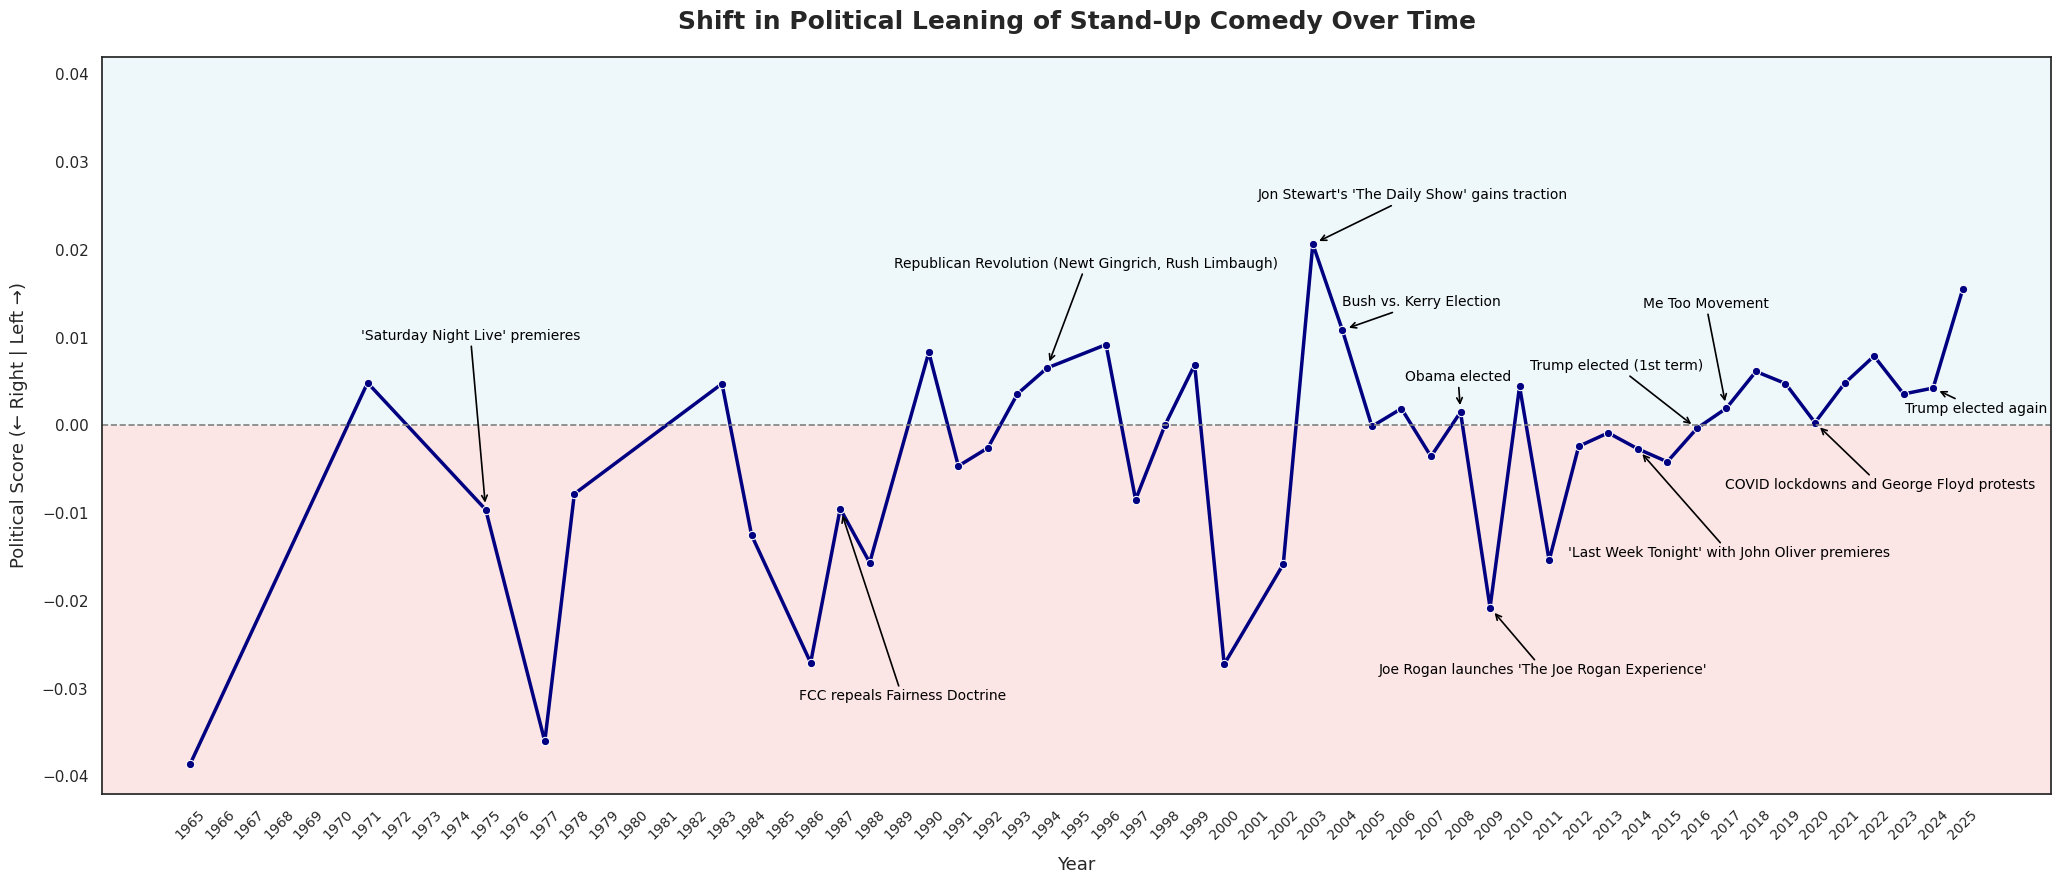

In [81]:
# @title
# Ensure year is numeric and sorted
yearly_scores['year'] = pd.to_numeric(yearly_scores['year'], errors='coerce')
yearly_scores = yearly_scores.sort_values('year')

# Set full range of years (for even spacing)
start_year = int(yearly_scores['year'].min())
end_year = int(yearly_scores['year'].max())

# Fill in missing years with NaN to create even spacing
all_years = pd.DataFrame({'year': range(start_year, end_year + 1)})
yearly_scores = all_years.merge(yearly_scores, on='year', how='left')

# Set figure style (no default gridlines)
sns.set_theme(style="white")  # removes seaborn whitegrid
plt.figure(figsize=(21, 9))

# Plot the political score line
sns.lineplot(
    data=yearly_scores,
    x='year',
    y='political_score',
    marker='o',
    linewidth=2.5,
    color='navy'
)

# Add only a horizontal line at y = 0
plt.axhline(0, color='gray', linestyle='--', linewidth=1.2)

# Titles and labels
plt.title("Shift in Political Leaning of Stand-Up Comedy Over Time", fontsize=18, weight='bold', pad=20)
plt.xlabel("Year", fontsize=13, labelpad=10)
plt.ylabel("Political Score (← Right | Left →)", fontsize=13, labelpad=10)

# Uniform x-axis ticks
plt.xticks(ticks=range(start_year, end_year + 1), rotation=45, fontsize=10)

# Turn off other grid lines
plt.grid(False)  # disables all
# Re-enable only the zero line (already done via axhline)

# Annotate specific years with arrows
highlight_years = {
    1975: "'Saturday Night Live' premieres",
    1987: "FCC repeals Fairness Doctrine",
    1994: "Republican Revolution (Newt Gingrich, Rush Limbaugh)",
    2003: "Jon Stewart's 'The Daily Show' gains traction",
    2004: "Bush vs. Kerry Election",
    2008: "Obama elected",
    2009: "Joe Rogan launches 'The Joe Rogan Experience'",
    2014: "'Last Week Tonight' with John Oliver premieres",
    2016: "Trump elected (1st term)",
    2017: "Me Too Movement",
    2020: "COVID lockdowns and George Floyd protests",
    2024: "Trump elected again"
}

for year, label in highlight_years.items():
    y_value = yearly_scores.loc[yearly_scores['year'] == year, 'political_score'].values
    if len(y_value) == 0 or pd.isna(y_value[0]):
        continue

    y = y_value[0]

    # Custom pixel offset per annotation
    if year == 1975:
        offset = (-90, 120)
    elif year == 1987:
        offset = (-30, -140)
    elif year == 1994:
        offset = (-110, 70)
    elif year == 2003:
        offset = (-40, 30)
    elif year == 2004:
        offset = (0, 15)
    elif year == 2008:
        offset = (-40, 20)
    elif year == 2009:
        offset = (-80, -50)
    elif year == 2014:
        offset = (-50, -80)
    elif year == 2016:
        offset = (-120, 40)
    elif year == 2017:
        offset = (-60, 70)
    elif year == 2020:
        offset = (-65, -50)
    elif year == 2024:
        offset = (-20, -20)
    else:
        offset = (5, 10)

    plt.annotate(
        text=label,
        xy=(year, y),
        xytext=offset,
        textcoords='offset points',
        arrowprops=dict(
            arrowstyle='->',
            color='black',
            lw=1.2,
            shrinkA=0,
            shrinkB=5
        ),
        fontsize=10,
        color='black',
        ha='left',
        va='bottom'
    )


# Shade above and below the zero line
plt.axhspan(0, 0.042, facecolor='lightblue', alpha=0.2, zorder=0)
plt.axhspan(-0.042, 0, facecolor='lightcoral', alpha=0.2, zorder=0)

# Final layout adjustments
plt.ylim(-0.042, 0.042)
plt.tight_layout()
plt.show()


## **So...Did Comedy Shift Politically?**

After embedding decades of stand-up specials and scoring them against presidential rhetoric, we can finally step back and look at the bigger picture. The chart gives us a look at how political leanings in comedy have evolved over time.

Here are the key insights that emerged:

### **The right-wing comedy "surge" is not clearly reflected...yet.**
Despite widespread media coverage about the rise of anti-woke or right-leaning comedy, the data doesn't show a significant or sustained shift to the political right. In fact, comedy has seen a somewhat steady trajectory towards the left since 2015. There are years where comedy dips slightly toward the Republican anchor, but these are isolated blips, not a trendline. This suggests that while right-leaning comedy may be gaining cultural traction in certain circles or platforms (particularly online), it hasn't yet made a large enough imprint on the mainstream, transcriptable body of stand-up to show up in the aggregate. In other words, the surge may be real in discourse, but it's not yet statistically dominant in the content.

\
### **Most comedy still hovers near neutral**
Rather than gravitating hard left or right, much of stand-up remains in a kind of ideological middle ground. After all, comedians have a lot of other things to talk about besides politics, like relationships, self-depreciation, and subway horror stories. It's a reminder that not all comedy is political, and most comics still just want to make you laugh, not win a debate.

\
\
While this model can give us a better sense of how stand-up comedy aligns semantically with political rhetoric over time, it's far from a perfect measure of a comedian's true ideology. It only captures comedians with taped, transcribed specials, leaving out vast corners of the stand-up world, from underground scenes to podcast-heavy performers. And while comparing stand-up to presidential speeches may offer a clever benchmark, it doesn't fully account for tone, irony, or context. After all, comedians don't speak like politicians, and they rarely mean exactly what they say. So while the trends are real, the nuance still lives between the lines, and in the laughs.

Thanks for checking this project out! And if you're still not convinced that the line between politics and comedy is blurry, I leave with this final data point:

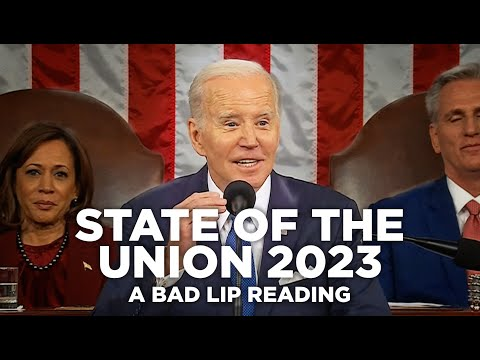

In [1]:
# @title
from IPython.display import YouTubeVideo

# Display the "State of the Union 2023 — A Bad Lip Reading" video
YouTubeVideo("iz19y9a9bsQ", width=800, height=450)